# Simulating asset returns with random walks

- *Continuous* random walk: The return is the derivative of the risky asset value S, and the safe asset value B
- We model the risky asset's prices like this:

$$ \frac{dS_t}{S_t} = \underbrace{(r + \sigma \lambda)}_{=\mu} dt + \sigma d W_t $$

- $S_t$ is the asset price at time $t$
- $\mu$ is the expected return (called the *drift* in the process)
  - $r$ is the risk free rate
  - $\sigma$ is the stock's volatility
  - $\lambda$ is the Sharpe ratio on that stock
- $dt$ is e.g. 1 month or 12 months  
- $W_t$ is the **Brownian motion** process, a continuous-time random walk

$$ \frac{dB_t}{B_t} = rdt \Leftrightarrow B_t = B_0 e^{rt} $$

# Discrete time formulation

Understand Brownian motion better by looking at discrete time first.


$$ \frac{dS_t}{S_t} = \frac{S_{t+dt}-S_t}{S_t} = (r+\sigma \lambda)dt+\sigma\sqrt{dt}\xi_t $$

- $\xi_t$ is a random variable with mean 0 and unit variance

# MC Simulation with time varying parameters

Before, we set the risk free rate $r$ to be fix over time. But it (like other parameters) varies, so it should be $r_t$!

A more general model:

$$ \frac{dS_t}{S_t} = (r_t + \underbrace{\sqrt{V_t}}_{=\sigma_t} \lambda_t^S) dt + \sqrt{V_t} dW_t^S $$

**Note**: It's not $W_t$ to the power of $S$, but it's the $W$ that *belongs* to the asset price $S$. Cause we'll have more $W$'s in a second


Let's introduce stochastic processes for the riskfree rate and the variance, to allow them to evolve over time:

$$dr_t = a(b-r_t)dt + \sigma_r dW_t^r$$

$a(b-r_t)$ is the deterministic component with a **mean-reverting feature**. $b$ is the long-term mean of the process. The Brownian motion $W_t$ is the random component.

$$dV_t = \alpha(\bar{V} - V_t)dt + \sigma_V\sqrt{V_t}dW_t^V$$

The $\sqrt{V_t}$ before the Brownian motion scales down the movement as the variance approaches zero from above. This ensures the variance's process will never become negative.

# Lab: Random Walk Generation

We'll implement this model, a [Geometric Brownian Motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion):

$$\frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma \sqrt{dt} \xi_t$$

A standard Brownian motion is symmetric up and down. In the *geometric* one, the *log* of the series (here: the annualized return) is a Brownian motion. The actual series (or better: Things like the 95% bands) then is not symmetric anymore.

It's a [Stochastic Differential Equation (SDE)](https://en.wikipedia.org/wiki/Stochastic_differential_equation). You can also write it as

$$dS_t = \mu S_t dt + \sigma S_t \sqrt{dt} dW_t$$

$\xi_t$ is a random Brownian motion $N(0,1)$, it's just a different character for $dW_t$.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
def gbm_slow(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    """A discretized (to `steps_per_year`) Geometric Brownian Motion generator.
    It simulates the evolution of a stock price.
    The mu and sigma defaults are annualized returns for the stock market.
    s_0 is the starting stock price"""
    
    # delta-time:
    dt = 1/steps_per_year
    n_steps = int(n_years * steps_per_year)
    
    # Generate a table: Each row is the new stock price, and each column is one possible scenario:
    xi = np.random.normal(size=(n_steps, n_scenarios))
    # Returns:
    rets = mu*dt + sigma*np.sqrt(dt)*xi
    rets = pd.DataFrame(rets)
    # To prices:
    prices = s_0*(1+rets).cumprod()
    
    return prices

In [3]:
def gbm(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    """A discretized (to `steps_per_year`) Geometric Brownian Motion generator.
    It simulates the evolution of a stock price.
    The mu and sigma defaults are annualized returns for the stock market.
    s_0 is the starting stock price"""
    
    # delta-time:
    dt = 1/steps_per_year
    n_steps = int(n_years * steps_per_year)
    
    # Generate a table: Each row is the new stock price, and each column is one possible scenario:
    rets_plus_1 = np.random.normal(loc=1+mu*dt, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1  # start the time series with price=100, not price=103.15 e.g.
    # To prices:
    prices = s_0*pd.DataFrame(rets_plus_1).cumprod()
    
    return prices

In [4]:
# %timeit gbm_slow(n_years=5, n_scenarios=1000)

In [5]:
# %timeit gbm(n_years=5, n_scenarios=1000)

In [6]:
p = gbm(n_scenarios=20)

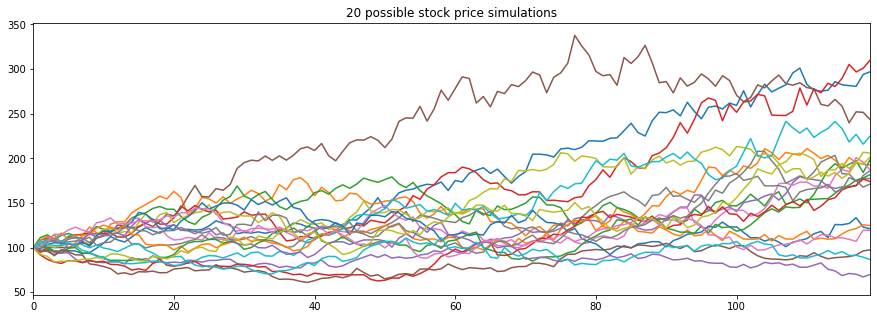

In [7]:
p.plot(legend=False, figsize=(15,5), title="20 possible stock price simulations")

# Analyzing CPPI strategies

In this video, he plotted these portfolio developments in a Shiny-like app, and then the same with using CPPI. The values never dropped below \$70.

$m=1$ means you put only your cushion in the risky asset. Then you will never have a threshold violation, but you're too conservative, too slow in growth.

# Lab - interactive plots of monte Carlo Simulations of CPPI and GBM

In [8]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import sys
sys.path.append('..')
import edhec_risk_kit as erk

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Interactive GBM plot

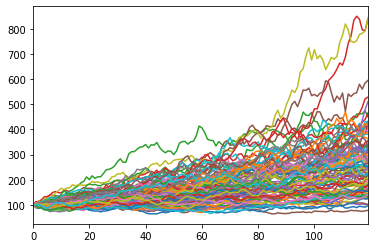

In [9]:
erk.gbm(n_years=10, n_scenarios=100, mu=0.1).plot(legend=False)

In [10]:
def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price eveolution under a Geometric
    Brownian Motion model
    """
    
    s_0 = 100
    prices = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0)
    ax = prices.plot(legend=False, color="indianred", alpha=0.5, linewidth=2, figsize=(15,5),
                    title="10 years of simulated stock returns")
    ax.axhline(y=s_0, ls=":", color="black")
    # draw a dot at the origin
    ax.plot(0, s_0, marker="o", color="darkred", alpha=0.2)

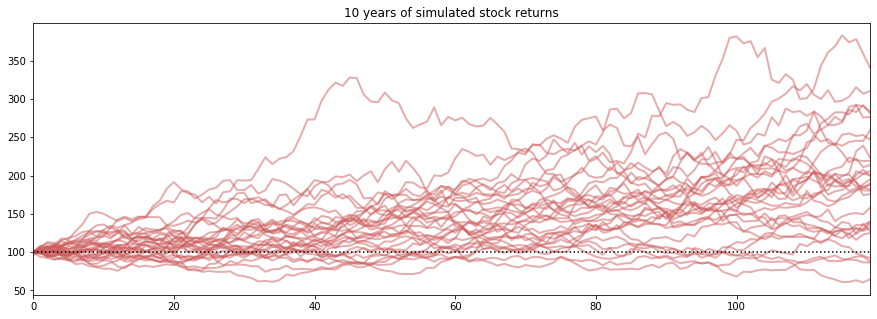

In [11]:
show_gbm(30, 0.07, 0.15)

In [12]:
gbm_controls = widgets.interactive(
    show_gbm,  # the function you want to make interactive
    n_scenarios = (0, 100, 5),  # min, max, stepsize
    mu = (0, 0.2, 0.01),
    sigma = (0, 0.3, 0.01)
)

In [13]:
display(gbm_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', step=5), FloatSlider(value=0.1, descripti…

### Interactive CPPI simulation - Monte Carlo

In [16]:
n_scenarios=50
mu=0.07
sigma=0.15
m=3
floor=0.
riskfree_rate=0.03
y_max=100
start = 100

sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
risky_r = pd.DataFrame(sim_rets)
# get the "back"-test results (btr):
btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
wealth = btr["Wealth"]
y_max=wealth.values.max()*y_max/100


In [15]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # get the "back"-test results (btr):
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    y_max=wealth.values.max()*y_max/100
    ax = wealth.plot(legend=False, alpha=0.3, color="indianred", figsize=(12, 6))
    ax.axhline(y=start, ls=":", color="black")
    ax.axhline(y=start*floor, ls="--", color="red")
    ax.set_ylim(top=y_max)

cppi_controls = widgets.interactive(show_cppi, 
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .30, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

# Adding a Histogram and Reporting Floor Violations

In [29]:
import matplotlib.pyplot as plt

def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    # Plot!
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, figsize=(24, 9),
                                             sharey=True, gridspec_kw={'width_ratios':[3,2]})
    plt.subplots_adjust(wspace=0.0)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='white', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")

cppi_controls = widgets.interactive(show_cppi, 
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .3, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

# Adding Terminal Wealth Statistics

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, steps_per_year=12, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=steps_per_year)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]

    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start*floor)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(terminal_wealth-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot!
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (floor > 0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=24)

cppi_controls = widgets.interactive(show_cppi,
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .3, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   steps_per_year=widgets.IntSlider(min=1, max=12, step=1, value=12,
                                                          description="Rebals/Year"),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…